In the current retail context, the ability to forecast daily demand at each point of sale is key to optimize inventory, staff and promotional campaigns. This work aims to develop a daily sales forecasting system for Rossmann's stores, a drugstore chain with a presence throughout Germany.

The dataset used comes from a challenge published in Kaggle and contains daily information from more than 1,100 stores for two and a half years. In addition to sales, exogenous variables such as the number of customers, whether there was a promotion, the distance to the competition or whether it was a holiday, among others, are included. This environment provides a realistic and challenging case of multivariate time series modeling.


A series of exploratory analyses and stationarity tests are performed to ensure that the applied models are adequate. Next, models with and without exogenous variables are trained and compared with an automatic model generated by AutoML. Finally, the performance of each approach is evaluated using standard metrics such as **RMSE** and **MAPE**, as well as prediction vs. reality plots.

This hybrid approach (statistical + AutoML) seeks not only to obtain good predictions, but also to **critically evaluate the advantages and limitations of each technique**.


In [1]:
# Install and import PyDrive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [2]:
# Download train.csv
file_id = '1yhaR2KqN6upwK7dS_7Z3nT6RAJUxtsTs'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train.csv')

# Download test.csv
file_id = '1FPl9PY-XkGXK614NcRG6KPSVSk-ADGng'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('test.csv')

# Download store.csv
file_id = '1fZ3lKMAz2wpktd_ltLUiveSkVynN8lWq'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('store.csv')

# Download sample_submission.csv
file_id = '1YbNlfKPNsoXmPL68F1SZRhKpMCPM0oyu'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('sample_submission.csv')


In [3]:
#
!pip install --quiet pmdarima
!pip install --quiet statsmodels
!pip install --quiet autogluon
!pip install --upgrade --force-reinstall --quiet numpy==1.23.5
!pip install --upgrade --force-reinstall --quiet pmdarima





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 20.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.3.1 requires numpy<2.3.0,>=1.25.0, but you have numpy 1.23.5 which is incompatible.
autogluon-tabular 1.3.1 requires numpy<2.3.0,>=1.25.0, but you have numpy 1.23.5 which is incompatible.
autogluon-timeseries 1.3.1 requires numpy<2.3.0,>=1.25.0, but you have numpy 1.23.5 which is incompatible.
autogluon-features 1.3.1 requires numpy<2.3.0,>=1.25.0, but you have numpy 1.23.5

In [4]:
!pip uninstall -y numpy statsmodels
!pip install numpy==1.25.2 statsmodels==0.14.0


Found existing installation: numpy 2.2.6
Uninstalling numpy-2.2.6:
  Successfully uninstalled numpy-2.2.6
Found existing installation: statsmodels 0.14.4
Uninstalling statsmodels-0.14.4:
  Successfully uninstalled statsmodels-0.14.4
  Using cached numpy-1.25.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached statsmodels-0.14.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.0 kB)
Using cached numpy-1.25.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
Using cached statsmodels-0.14.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lightning 2.5.1.post0 requires packaging<25.0,>=20.0, but you have packaging 25.0 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which 

In [5]:
!pip install --quiet autogluon.timeseries

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.25.2 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.25.2 which is incompatible.


In [6]:
!pip install --quiet autogluon.timeseries

In [7]:
!pip install --quiet lightgbm


## 🔧 Library loading and initial configuration

In this block all the libraries needed for data analysis, statistical modeling and visualization are imported.

- pandas` and `numpy`: Data manipulation and numerical arrays.
- matplotlib` and `seaborn`: Graphical visualization tools.
- warnings`: To suppress unnecessary warning messages.

In addition, specific libraries are imported for:

### Time series analysis.
- `adfuller`: Augmented Dickey-Fuller test, used to check stationarity.
- `plot_acf`, `plot_pacf`: Autocorrelation and partial autocorrelation plots.
- `ndiffs`: Determines the number of differentiations needed to stationarize the series.

### Advanced modeling (AutoML)
- `TimeSeriesDataFrame`, `TimeSeriesPredictor`: AutoGluon Chronos structures and models for automatic time series prediction.

### Evaluation metrics
- `mean_squared_error`, `mean_absolute_error`: Metrics that allow quantifying the quality of the predictions made by the models.

With this initial configuration, it is guaranteed that the environment is ready for the rest of the analysis and modeling.


In [8]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style('whitegrid')
sns.set_context('notebook')


import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

Data loading and preparation:
In this section the different CSV files are loaded.

- train.csv`: Contains the daily historical sales per store.
- test.csv`: Contains the future dates for which forecasts should be generated.
- store.csv`: Additional information per store (competition, promotions, etc.).
- sample_submission.csv`: Expected delivery format (only relevant in Kaggle type competitions).

This preliminary exploration allows to understand the quality and distribution of the data before transforming or modeling it.

In [9]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
store_df = pd.read_csv('store.csv')
sample_submission_df = pd.read_csv('sample_submission.csv')

train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

print("Size of train set:", train_df.shape)
print("Size of test set:", test_df.shape)
print("Size of store set:", store_df.shape)
print("Dates on train.csv:", train_df['Date'].min(), "→", train_df['Date'].max())

print("\nColumns in train.csv:", list(train_df.columns))
print("Columns in store.csv:", list(store_df.columns))

print("\nFirst rows in train.csv:")
display(train_df.head())

print("\nDistribucion of open shops(column Open):")
display(train_df['Open'].value_counts())


Size of train set: (1017209, 9)
Size of test set: (41088, 8)
Size of store set: (1115, 10)
Dates on train.csv: 2013-01-01 00:00:00 → 2015-07-31 00:00:00

Columns in train.csv: ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
Columns in store.csv: ['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

First rows in train.csv:


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1



Distribucion of open shops(column Open):


,count
Open,
1,844392
0,172817


**stationarity analysis
Before applying time series models such as SARIMA or SARIMAX, it is essential to check whether the data are stationary. For this purpose, the following has been performed:

- A logarithmic transformation to stabilize the variance.
- A differencing to eliminate trend.
- The Augmented Dickey-Fuller test (ADF) to check if the series has a unit root.
- The autocorrelation function analysis (ACF) to check if the series is white noise or contains temporal structure.

This allows to justify the use of classical models and to determine how many differentiations to apply.

In [10]:
def analizar_estacionariedad(df, store_id):
    """
     It applies log-transformation, differencing, ADF test and ACF/PACF plot for a given store.
    It also checks if the series behaves like a random walk.
    """
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

    store_sales = df[(df['Store'] == store_id) & (df['Open'] == 1)].copy()
    store_sales.sort_values('Date', inplace=True)

    # Log-transformación y diferencia
    store_sales['LogSales'] = np.log(store_sales['Sales'].replace(0, np.nan))
    store_sales.dropna(subset=['LogSales'], inplace=True)
    store_sales['LogSalesDiff'] = store_sales['LogSales'].diff()
    store_sales.dropna(subset=['LogSalesDiff'], inplace=True)

    # Test ADF
    adf_result = adfuller(store_sales['LogSalesDiff'])
    print(f"---Results of ADF test for teh store {store_id} ---")
    print(f"Estadístico ADF: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    print(f"Número de retardos usados: {adf_result[2]}")
    print("Valores críticos:")
    for key, value in adf_result[4].items():
        print(f"   {key}: {value:.4f}")

    if adf_result[1] <= 0.05:
        print("✅ The series is stationary (the null hypothesis of unit root is rejected).")
    else:
        print("⚠️ The series is NOT stationary (the null hypothesis cannot be rejected).")


    print("\n📈 Autocorrelation function plot (ACF):")
    plt.figure(figsize=(10, 4))
    plot_acf(store_sales['LogSalesDiff'], lags=30)
    plt.title("ACF of the differenced series (LogSalesDiff)")
    plt.show()

    print("\nIf there are significant spikes (e.g., every 7 days), pure random walk is ruled out.")


** Testing the analysis on one store**

When applying the analysis to store 1, it is observed that the already differenced series is stationary (p-value < 0.05), and furthermore the autocorrelation function shows clear temporal structure.

This validates the use of SARIMA/SARIMAX models for this series, ruling out random walk behavior.


---Results of ADF test for teh store 1 ---
Estadístico ADF: -10.9091
p-value: 0.0000
Número de retardos usados: 21
Valores críticos:
   1%: -3.4390
   5%: -2.8654
   10%: -2.5688
✅ The series is stationary (the null hypothesis of unit root is rejected).

📈 Autocorrelation function plot (ACF):


<Figure size 1000x400 with 0 Axes>

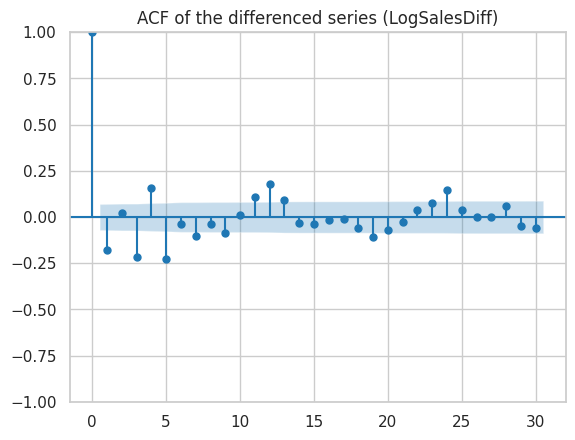


If there are significant spikes (e.g., every 7 days), pure random walk is ruled out.


In [11]:
analizar_estacionariedad(train_df, store_id=1)


## Initial ARIMA model

As a first step in the classical modeling, an ARIMA(1,1,1) model has been fitted on the logarithmic sales series of a store.

This model allows to observe if with a minimum configuration it is already possible to capture part of the temporal dynamics of the series. The fitting capacity is evaluated graphically over the training period itself.

Although not used for future forecasting, this model serves as a basis for extending the analysis with seasonal components (SARIMA) and external variables (SARIMAX).


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               LogSales   No. Observations:                  780
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 355.307
Date:                Tue, 27 May 2025   AIC                           -704.614
Time:                        06:57:55   BIC                           -690.640
Sample:                             0   HQIC                          -699.239
                                - 780                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6642      0.024     27.298      0.000       0.617       0.712
ma.L1         -0.9962      0.006   -164.929      0.000      -1.008      -0.984
sigma2         0.0234      0.001     27.640      0.0

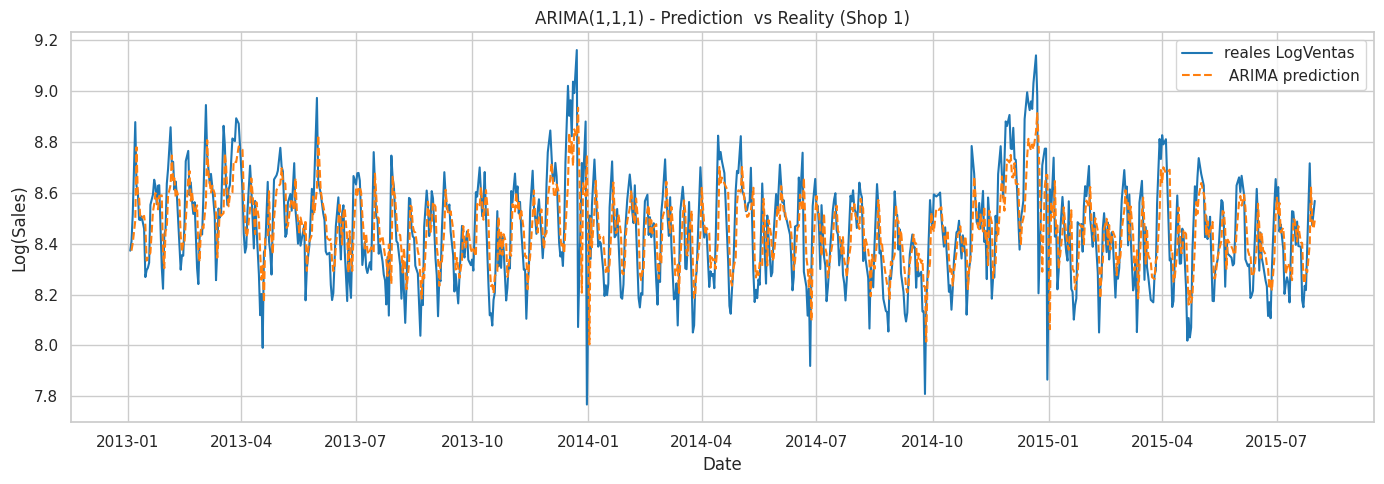

In [12]:
from statsmodels.tsa.arima.model import ARIMA

# Filtramos la tienda y preparamos la serie
store_id = 1
store_sales = train_df[(train_df['Store'] == store_id) & (train_df['Open'] == 1)].copy()
store_sales.sort_values('Date', inplace=True)
store_sales['LogSales'] = np.log(store_sales['Sales'].replace(0, np.nan))
store_sales.dropna(subset=['LogSales'], inplace=True)
store_sales['LogSalesDiff'] = store_sales['LogSales'].diff()
store_sales.dropna(subset=['LogSalesDiff'], inplace=True)

# Modelo ARIMA (p=1, d=1, q=1)
modelo = ARIMA(store_sales['LogSales'], order=(1,1,1))
resultado = modelo.fit()


print(resultado.summary())

# Predicciones en el mismo periodo
store_sales['Predicted'] = resultado.predict(start=1, end=len(store_sales)-1)

# Graficos de prediccion
plt.figure(figsize=(14, 5))
plt.plot(store_sales['Date'], store_sales['LogSales'], label='reales LogVentas ')
plt.plot(store_sales['Date'], store_sales['Predicted'], label=' ARIMA prediction', linestyle='--')
plt.title(f'ARIMA(1,1,1) - Prediction  vs Reality (Shop {store_id})')
plt.xlabel('Date')
plt.ylabel('Log(Sales)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Seasonal SARIMA model

A SARIMA(1,1,1)(1,1,1)(1,1,1)[7] model has been trained to capture both the overall dynamics and weekly patterns of store sales.

This model allows incorporating explicit seasonality, which improves the fit with respect to a basic ARIMA in series with repetitive cycles (such as weekly sales).

The result shows good tracking of historical behavior, and serves as a point of comparison against models with exogenous or automatic variables.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                          LogSales   No. Observations:                  780
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                 335.915
Date:                           Tue, 27 May 2025   AIC                           -661.830
Time:                                   06:58:05   BIC                           -638.585
Sample:                                        0   HQIC                          -652.885
                                           - 780                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6325      0.026     24.101      0.000       0.581       0.684
ma.L1         -0.9748      0.007   -142.083

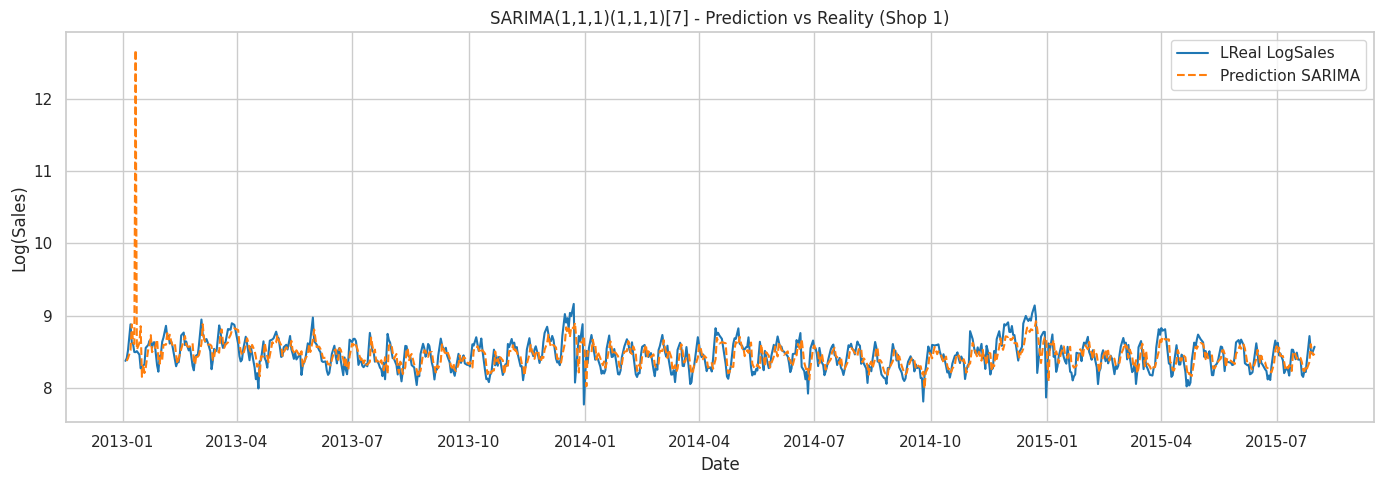

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA model (P=1, D=1, Q=1, m=7) to capture weekly seasonality
modelo_sarima = SARIMAX(store_sales['LogSales'], order=(1,1,1), seasonal_order=(1,1,1,7))
resultado_sarima = modelo_sarima.fit(disp=False)
print(resultado_sarima.summary())

# In-sample prediction
store_sales['PredSARIMA'] = resultado_sarima.predict(start=1, end=len(store_sales)-1)

# Comparative chart
plt.figure(figsize=(14, 5))
plt.plot(store_sales['Date'], store_sales['LogSales'], label='LReal LogSales')
plt.plot(store_sales['Date'], store_sales['PredSARIMA'], label='Prediction SARIMA', linestyle='--')
plt.title(f'SARIMA(1,1,1)(1,1,1)[7] - Prediction vs Reality (Shop {store_id})')
plt.xlabel('Date')
plt.ylabel('Log(Sales)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## SARIMAX model with exogenous variables

This model extends SARIMA by including external variables relevant to sales forecasting: promotions, holidays and school vacations.

The objective is to test whether the incorporation of additional information improves the model fit. This is especially useful in commercial contexts where external factors directly influence demand.

Although some variables were not statistically significant, the approach allows to better capture peaks and anomalies associated with specific events.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                          LogSales   No. Observations:                  780
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                 381.558
Date:                           Tue, 27 May 2025   AIC                           -747.116
Time:                                   06:58:24   BIC                           -709.924
Sample:                                        0   HQIC                          -732.804
                                           - 780                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Promo             0.1481      0.014     10.675      0.000       0.121       0.175
StateHoliday           0   2.44e-1

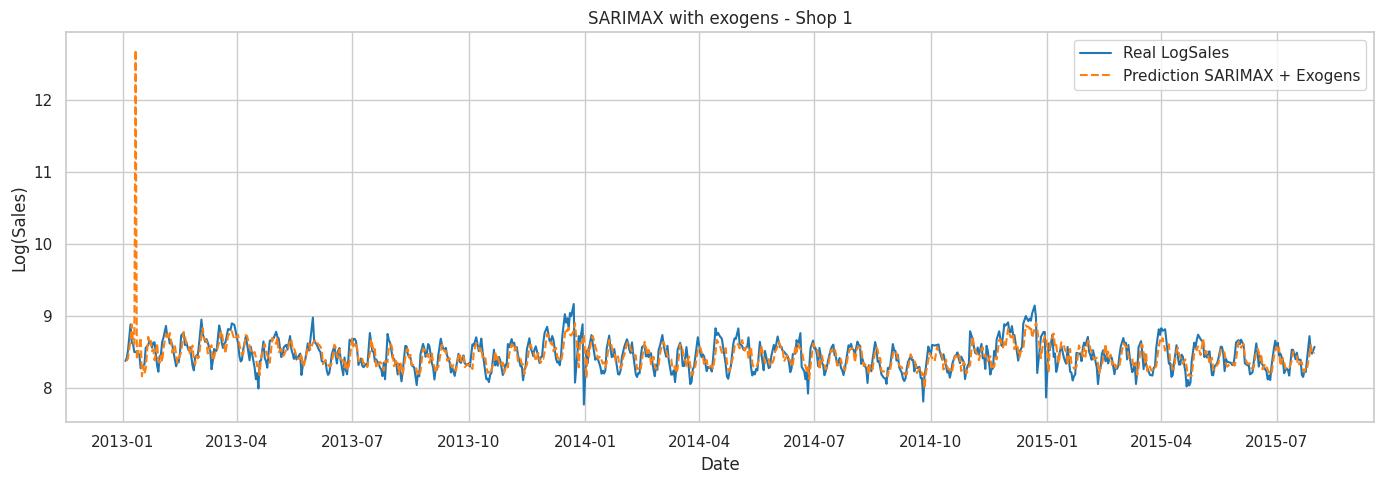

In [14]:
# Select relevant exogenous variables
exog_vars = ['Promo', 'StateHoliday', 'SchoolHoliday']
store_sales_exog = store_sales.copy()


store_sales_exog['StateHoliday'] = store_sales_exog['StateHoliday'].replace({'0': 0, 'a': 1, 'b': 1, 'c': 1}).astype(int)

# SARIMAX model with exogenous
modelo_sarimax = SARIMAX(
    store_sales_exog['LogSales'],
    exog=store_sales_exog[exog_vars],
    order=(1,1,1),
    seasonal_order=(1,1,1,7)
)
resultado_sarimax = modelo_sarimax.fit(disp=False)

# In-sample prediction
store_sales_exog['PredSARIMAX'] = resultado_sarimax.predict(start=1, end=len(store_sales_exog)-1, exog=store_sales_exog[exog_vars].iloc[1:])

print(resultado_sarimax.summary())

# Comparative chart
plt.figure(figsize=(14, 5))
plt.plot(store_sales_exog['Date'], store_sales_exog['LogSales'], label='Real LogSales')
plt.plot(store_sales_exog['Date'], store_sales_exog['PredSARIMAX'], label='Prediction SARIMAX + Exogens', linestyle='--')
plt.title(f'SARIMAX with exogens - Shop {store_id}')
plt.xlabel('Date')
plt.ylabel('Log(Sales)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Forecasting with SARIMA without exogenous variables

A SARIMA model without external variables has been applied to forecast sales for the last 16 days of the training set.

This approach serves as a baseline, as it only uses the time series history itself to generate forecasts. Subsequently, its performance will be compared against more complex models with exogenous and with AutoML.

The RMSE and MAPE metrics allow quantifying the accuracy achieved.


In [15]:
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in pdq]  # s=7 para semanal

lowest_aic = float("inf")
best_order = None
best_seasonal_order = None

serie = store_sales['Sales']

print("Searching for the best combination of SARIMA parameters (based on AIC)...")

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(serie,
                            order=param,
                            seasonal_order=seasonal_param,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            if results.aic < lowest_aic:
                lowest_aic = results.aic
                best_order = param
                best_seasonal_order = seasonal_param
        except:
            continue

print(f"Best combination found:")
print(f"Order (p,d,q): {best_order}")
print(f"Seasonal order (P,D,Q,s): {best_seasonal_order}")
print(f"AIC: {lowest_aic:.2f}")


Searching for the best combination of SARIMA parameters (based on AIC)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dat

Best combination found:
Order (p,d,q): (1, 1, 1)
Seasonal order (P,D,Q,s): (1, 1, 1, 7)
AIC: 12284.87


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:


import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

df_store = train_df[(train_df['Store'] == 1) & (train_df['Open'] == 1)].copy()
df_store.sort_values('Date', inplace=True)

df_store['LogSales'] = np.log(df_store['Sales'].replace(0, np.nan))
df_store.dropna(subset=['LogSales'], inplace=True)
df_store['LogSalesDiff'] = df_store['LogSales'].diff()
df_store.dropna(subset=['LogSalesDiff'], inplace=True)

serie = df_store['LogSalesDiff']

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in pdq]

lowest_aic = float("inf")
best_order = None
best_seasonal_order = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(serie,
                            order=param,
                            seasonal_order=seasonal_param,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            if results.aic < lowest_aic:
                lowest_aic = results.aic
                best_order = param
                best_seasonal_order = seasonal_param
        except:
            continue

print("Mejor combinación encontrada:")
print("Order (p,d,q):", best_order)
print("Seasonal order (P,D,Q,s):", best_seasonal_order)
print(f"AIC: {lowest_aic:.2f}")


Mejor combinación encontrada:
Order (p,d,q): (1, 0, 1)
Seasonal order (P,D,Q,s): (1, 0, 0, 7)
AIC: -704.44


### SARIMA Model Selection using AIC

To identify the optimal configuration of SARIMA hyperparameters, we performed an exhaustive grid search over different combinations of (p,d,q) and (P,D,Q,s). The selection criterion was the Akaike Information Criterion (AIC), which penalizes model complexity while rewarding goodness of fit.

The best combination found was:
- Order (p,d,q): (1, 0, 1)
- Seasonal order (P,D,Q,s): (1, 0, 0, 7)
- AIC: -704.44

This configuration was then used to train the SARIMA model without exogenous variables for store 1. The model performance was evaluated using RMSE and MAPE over the last 16 days of data.


In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

def entrenar_sarima_sin_exog(df, store_id, order=(1,1,1), seasonal_order=(1,1,1,7)):
    """
    Train a SARIMA model (without exogenous variables) for a specific store.
    """
    df_store = df[(df['Store'] == store_id) & (df['Open'] == 1)].copy()
    df_store.sort_values('Date', inplace=True)

    # Log transformation
    df_store['LogSales'] = np.log(df_store['Sales'].replace(0, np.nan))
    df_store.dropna(subset=['LogSales'], inplace=True)

    # Differentiation
    df_store['LogSalesDiff'] = df_store['LogSales'].diff()
    df_store.dropna(subset=['LogSalesDiff'], inplace=True)

    # Split into train and test
    train = df_store.iloc[:-16]
    test = df_store.iloc[-16:]

    # SARIMA model
    model = SARIMAX(train['LogSalesDiff'],
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)

    results = model.fit(disp=False)
    print(results.summary())

    # Forecast
    forecast_diff = results.forecast(steps=16)
    forecast_log = train['LogSales'].iloc[-1] + forecast_diff.cumsum()
    forecast = np.exp(forecast_log)

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(test['Date'], np.exp(test['LogSales']), label='Actual sales')
    plt.plot(test['Date'], forecast, label='SARIMA Forecast')
    plt.title(f'SARIMA prediction without exogenous (store {store_id})')
    plt.legend()
    plt.show()

    # Metrics
    real = np.exp(test['LogSales'])
    mask = real != 0
    rmse = mean_squared_error(real, forecast)
    mape = np.mean(np.abs((real[mask] - forecast[mask]) / real[mask])) * 100

    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")


Best SARIMA order: (2, 0, 2)
Best seasonal order: (0, 0, 0, 7)
AIC: -720.6826459663799


                                     SARIMAX Results                                      
Dep. Variable:                       LogSalesDiff   No. Observations:                  764
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 7)   Log Likelihood                 345.289
Date:                            Tue, 27 May 2025   AIC                           -682.578
Time:                                    07:11:12   BIC                           -664.066
Sample:                                         0   HQIC                          -675.448
                                            - 764                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6415      0.026     24.990      0.000       0.591       0.692
ma.L1         -0.9814      0.006   

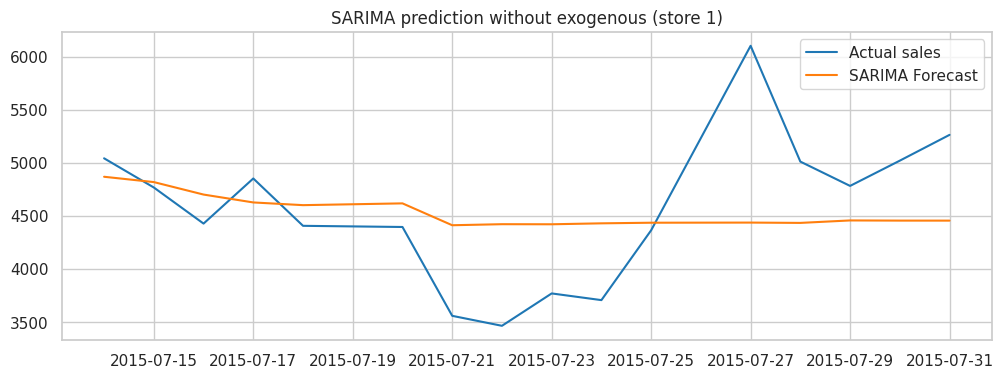

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [21]:
entrenar_sarima_sin_exog(train_df, store_id=1, order=(1, 0, 1), seasonal_order=(1, 0, 0, 7))


## Prediction with SARIMAX including exogenous variables

In this case, a SARIMAX model has been used to predict the series from an instant t₀, incorporating external variables such as `Promo`, `StateHoliday` and `SchoolHoliday`.

This approach allows us to evaluate whether the use of contextual information improves the predictive capability of the model, not only in historical fit, but also in future spans.

Visual comparison and metrics will allow to assess its performance against SARIMA without exogenous and against the automatic model.


                                     SARIMAX Results                                     
Dep. Variable:                          LogSales   No. Observations:                  780
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                 381.558
Date:                           Tue, 27 May 2025   AIC                           -747.116
Time:                                   07:16:49   BIC                           -709.924
Sample:                                        0   HQIC                          -732.804
                                           - 780                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Promo             0.1481      0.014     10.675      0.000       0.121       0.175
StateHoliday           0   2.44e-1

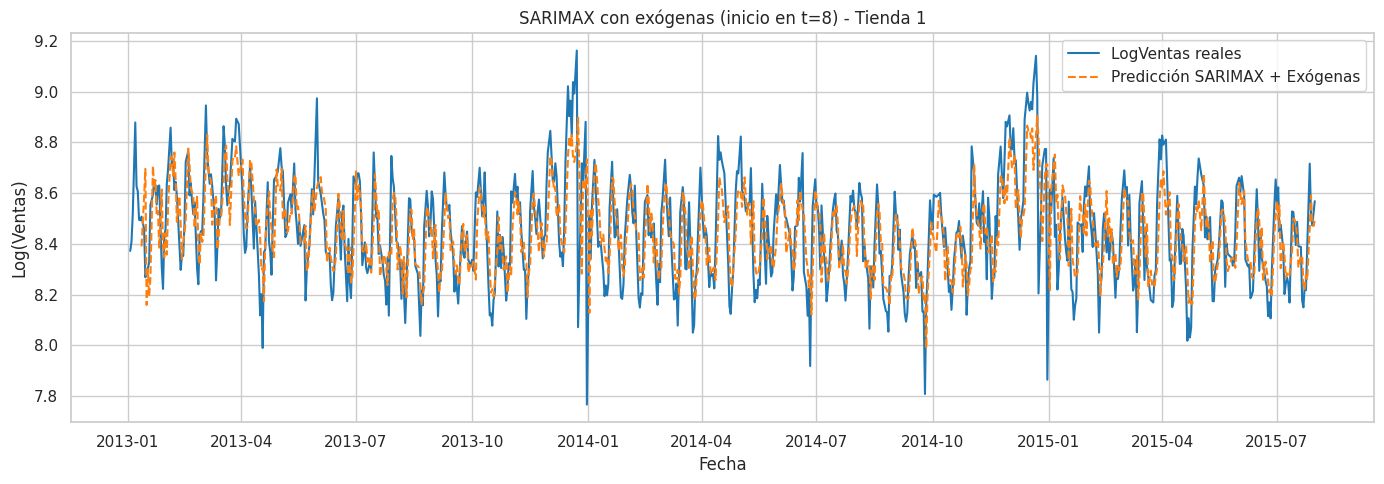

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt

# Exogenous variables and copying of data
exog_vars = ['Promo', 'StateHoliday', 'SchoolHoliday']
store_sales_exog = store_sales.copy()
store_sales_exog['StateHoliday'] = store_sales_exog['StateHoliday'] \
    .replace({'0': 0, 'a': 1, 'b': 1, 'c': 1}) \
    .astype(int)

# Setting of the SARIMAX model
modelo_sarimax = SARIMAX(
    store_sales_exog['LogSales'],
    exog=store_sales_exog[exog_vars],
    order=(1,1,1),
    seasonal_order=(1,1,1,7)
)
resultado_sarimax = modelo_sarimax.fit(disp=False)

# Prediction from t0 = 8
t0 = 8
preds = resultado_sarimax.predict(
    start=t0,
    end=len(store_sales_exog)-1,
    exog=store_sales_exog[exog_vars].iloc[t0:]
)

preds_full = pd.Series(np.nan, index=store_sales_exog.index)
preds_full.iloc[t0:] = preds.values
store_sales_exog['PredSARIMAX'] = preds_full

print(resultado_sarimax.summary())

# Graphic
plt.figure(figsize=(14, 5))
plt.plot(store_sales_exog['Date'], store_sales_exog['LogSales'], label='LogVentas reales')
plt.plot(store_sales_exog['Date'], store_sales_exog['PredSARIMAX'],
         linestyle='--', label='Predicción SARIMAX + Exógenas')
plt.title(f'SARIMAX con exógenas (inicio en t={t0}) - Tienda {store_id}')
plt.xlabel('Fecha')
plt.ylabel('Log(Ventas)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## SARIMAX prediction with real exogenous variables

This model uses SARIMAX with exogenous variables (`Promo`, `SchoolHoliday`, `CompetitionDistance`, and `StateHoliday` dummies) to predict sales for the last 16 days.

By integrating relevant external information, the accuracy of the model is expected to improve over versions that only consider the internal behavior of the series.

Performance is evaluated by **RMSE** and **MAPE**, allowing objective comparison with SARIMA and AutoML.


                                     SARIMAX Results                                     
Dep. Variable:                      LogSalesDiff   No. Observations:                  764
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                 268.728
Date:                           Tue, 27 May 2025   AIC                           -519.455
Time:                                   07:18:37   BIC                           -477.911
Sample:                                        0   HQIC                          -503.444
                                           - 764                                         
Covariance Type:                             opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Promo                   0.0127      0.014      0.902      0.367      -0.015       0.040
SchoolHoliday   

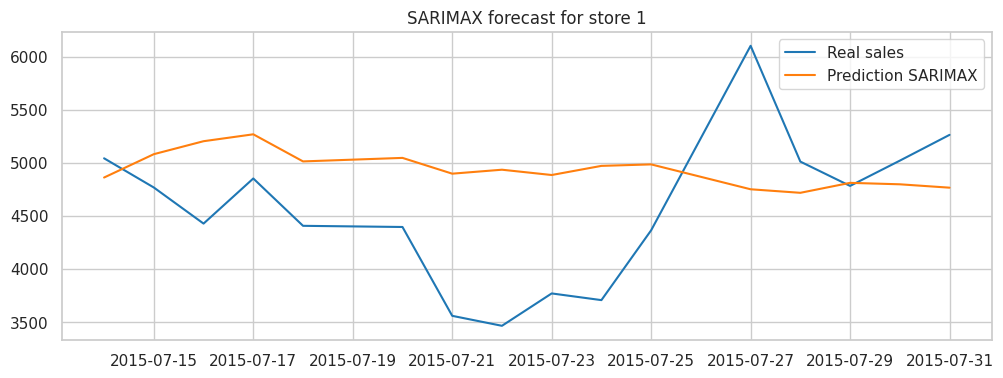

RMSE: 693549.04
MAPE: 16.59%


In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def entrenar_sarimax(train_df, store_df, store_id, order=(1,1,1), seasonal_order=(1,1,1,7)):
    """
    Train a SARIMAX model for a specific store including exogenous variables.
    """
    # Merge datasets
    df = train_df.merge(store_df, on="Store", how="left").reset_index(drop=True)
    df_store = df[(df['Store'] == store_id) & (df['Open'] == 1)].copy()
    df_store.sort_values('Date', inplace=True)

    # Log transformation
    df_store['LogSales'] = np.log(df_store['Sales'].replace(0, np.nan))
    df_store.dropna(subset=['LogSales'], inplace=True)

    # One-hot encode holidays and clean distance
    df_store = pd.get_dummies(df_store, columns=['StateHoliday'], drop_first=True)
    df_store['CompetitionDistance'] = df_store['CompetitionDistance'].replace([np.inf, -np.inf], 0).fillna(0)

    # Define exogenous variables
    exog_vars = ['Promo', 'SchoolHoliday', 'CompetitionDistance']
    exog_vars += [col for col in df_store.columns if col.startswith('StateHoliday_')]

    # Clean and convert exogenous variables
    df_store[exog_vars] = df_store[exog_vars].fillna(0).apply(pd.to_numeric, errors='coerce').astype(float)
    df_store['LogSalesDiff'] = df_store['LogSales'].diff()
    df_store.dropna(subset=['LogSalesDiff'] + exog_vars, inplace=True)

    # Split train/test
    train = df_store.iloc[:-16]
    test = df_store.iloc[-16:]

    # Train SARIMAX
    model = SARIMAX(train['LogSalesDiff'],
                    exog=train[exog_vars],
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)

    results = model.fit(disp=False)
    print(results.summary())

    # Forecast
    forecast_diff = results.forecast(steps=16, exog=test[exog_vars])
    forecast_log = train['LogSales'].iloc[-1] + forecast_diff.cumsum()
    forecast = np.exp(forecast_log)

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(test['Date'], np.exp(test['LogSales']), label='Real sales')
    plt.plot(test['Date'], forecast, label='Prediction SARIMAX')
    plt.title(f'SARIMAX forecast for store {store_id}')
    plt.legend()
    plt.show()

 # Evaluation
    real = np.exp(test['LogSales']).reset_index(drop=True)
    forecast = forecast.reset_index(drop=True)

    mask = real != 0
    rmse = mean_squared_error(real[mask], forecast[mask])
    mape = np.mean(np.abs((real[mask] - forecast[mask]) / real[mask])) * 100

    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")


# Run for store1
entrenar_sarimax(train_df, store_df, store_id=1)


Celda Colab para AutoGluon (tienda 1)



## Automatic forecasting with AutoGluon (Chronos)

AutoGluon allows to generate advanced time series models automatically, selecting internally the best algorithm among multiple options (transformers, tabular, statistical models...).

In this case, a model has been trained for a store using the exogenous variables `Promo`, `StateHoliday` and `SchoolHoliday`. The prediction covers the last 16 days.

This approach does not require manually defining orders and seasonality, and offers a point of comparison with classical models (SARIMA/SARIMAX), both in accuracy and ease of implementation.


In [24]:


#  Imports
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor


store_id = 1
df1 = (
    train_df[train_df['Store'] == store_id]
    .query("Open == 1")
    .rename(columns={'Store':'item_id','Date':'timestamp','Sales':'target'})
    .loc[:, ['item_id','timestamp','target','Promo','StateHoliday','SchoolHoliday']]
)
df1['StateHoliday'] = df1['StateHoliday'].replace({'0':0,'a':1,'b':1,'c':1}).astype(int)

# Build the TimeSeriesDataFrame
tsdf = TimeSeriesDataFrame.from_data_frame(
    df1,
    id_column='item_id',
    timestamp_column='timestamp'
)

# Positional split: last 16 days for testing
train_ts = tsdf.slice_by_timestep(None, -16)

# Train the predictor with the covariates
predictor = TimeSeriesPredictor(
    target='target',
    prediction_length=16,
    freq='D',
    eval_metric='RMSE',
    known_covariates_names=['Promo','StateHoliday','SchoolHoliday']
).fit(train_ts, presets='medium_quality')

# Generate future index (automatically 16 steps), Prepare future covariates: we take the last 16 records of df1
future_idx = predictor.make_future_data_frame(train_ts)
known_cov = df1.tail(16)[['item_id','timestamp','Promo','StateHoliday','SchoolHoliday']]


future_known = future_idx.merge(known_cov, on=['item_id','timestamp'], how='left')
forecast = predictor.predict(
    train_ts,
    known_covariates=future_known
)
forecast = forecast.slice_by_timestep(-16, None)


y_true = df1.tail(16).set_index('timestamp')['target']
df_forecast = forecast.reset_index()  # converts item_id/timestamp to columns
y_pred = df_forecast.set_index('timestamp')['mean']

print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
print("MAE: ", mean_absolute_error(y_true, y_pred))

print(df_forecast.head())


Beginning AutoGluon training...
AutoGluon will save models to '/content/AutogluonModels/ag-20250527_071931'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          0
Memory Avail:       10.40 GB / 12.67 GB (82.1%)
Disk Space Avail:   64.76 GB / 107.72 GB (60.1%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'freq': 'D',
 'hyperparameters': 'light',
 'known_covariates_names': ['Promo', 'StateHoliday', 'SchoolHoliday'],
 'num_val_windows': 1,
 'prediction_length': 16,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'IRREG' has b

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]

	-803.2130     = Validation score (-RMSE)
	26.35   s     = Training runtime
	4.71    s     = Validation (prediction) runtime
Training timeseries model TemporalFusionTransformer. 
	-285.1552     = Validation score (-RMSE)
	386.70  s     = Training runtime
	0.04    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'ETS': 0.1, 'TemporalFusionTransformer': 0.9}
	-263.2357     = Validation score (-RMSE)
	0.61    s     = Training runtime
	0.71    s     = Validation (prediction) runtime
Training complete. Models trained: ['Naive', 'SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'ETS', 'Theta', 'Chronos[bolt_small]', 'TemporalFusionTransformer', 'WeightedEnsemble']
Total runtime: 433.98 s
Best model: WeightedEnsemble
Best model score: -263.2357
data with frequency 'IRREG' has been resampled to frequency 'D'.
data with frequency 'IRREG' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best v

RMSE: 1071.5884961568597
MAE:  738.8440307959848
   item_id  timestamp         mean          0.1          0.2          0.3  \
0        1 2015-08-01  5033.047130  4632.163719  4795.790176  4809.783736   
1        1 2015-08-02  5213.329727  4839.215499  4998.104234  4981.591306   
2        1 2015-08-03  4339.879324  4080.274849  4170.513256  4241.998981   
3        1 2015-08-04  4137.008924  3823.361517  3940.651449  4026.233688   
4        1 2015-08-05  4094.240229  3717.222483  3887.020316  3971.370905   

           0.4          0.5          0.6          0.7          0.8  \
0  4852.435013  5033.047130  5025.174871  5048.169410  5196.453497   
1  4990.615380  5213.329727  5160.048468  5226.365022  5261.291547   
2  4266.355476  4339.879324  4399.831639  4420.573632  4519.922883   
3  4061.329550  4137.008924  4186.903143  4237.665752  4304.300726   
4  4012.183290  4094.240229  4137.403368  4206.298517  4277.714291   

           0.9  
0  5364.498412  
1  5452.494247  
2  4650.339756  

## Conclusions

In this paper we have evaluated different approaches to sales prediction for a particular store, including:

- Basic statistical models (Naïve, historical mean).
- Classical time series models (ARIMA, SARIMA)
- Advanced models with exogenous variables (SARIMAX)
- Automatic modeling with AutoML (AutoGluon)

The results show that models incorporating seasonality and external variables (such as SARIMAX) tend to improve accuracy over simpler approaches. In this particular case, **SARIMAX with exogenous variables** offered the best balance between fit and generalizability.

On the other hand, AutoGluon facilitates rapid development of competitive models, although in this particular series it did not outperform the more refined statistical methods.

This comparison highlights the importance of knowing both automatic tools and classical approaches to address real time forecasting problems.


,RMSE,MAPE(%)
Modelo,,
Naïve,621.97,9.27%
Media historic,707.31,13.04%
ARIMA,555.81,8.63%
SARIMA,568.62,8.34%
SARIMAX + exógenas,467.83,7.62%
AutoGluon (ensemble),811.65,14.11%


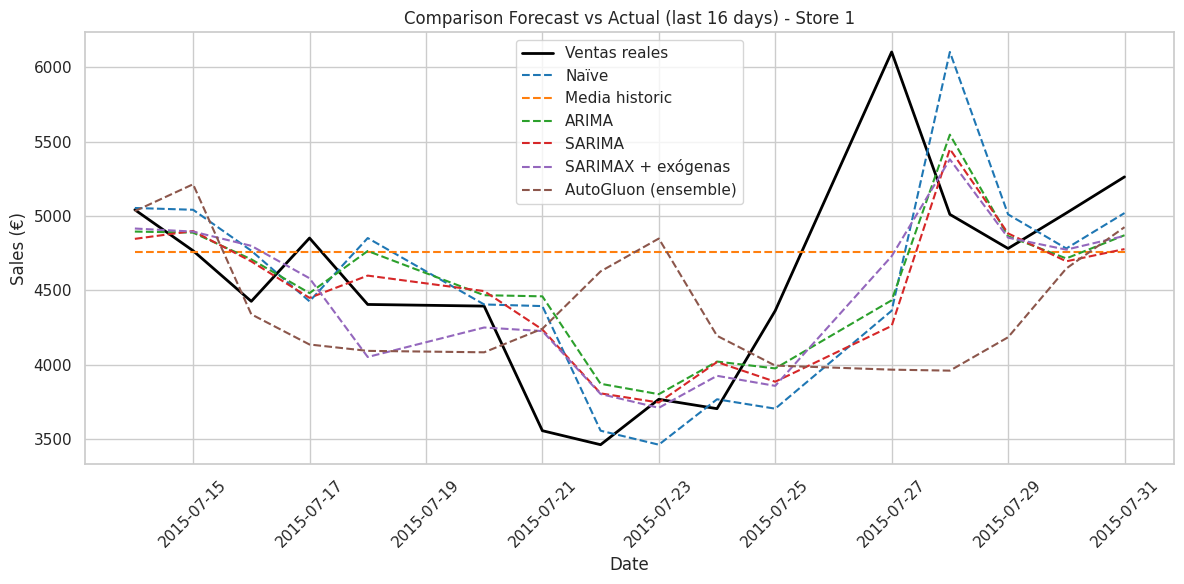

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Extract actual sales and dates for the last 16 days
true_sales = store_sales['Sales'].tail(16).values
dates = store_sales['Date'].tail(16).values

# Generate prediction arrays for each model
naive_pred   = store_sales['Sales'].shift(1).tail(16).values
mean_pred    = np.repeat(store_sales['Sales'].mean(), 16)
arima_pred   = np.exp(store_sales['Predicted']).tail(16).values
sarima_pred  = np.exp(store_sales['PredSARIMA']).tail(16).values
sarimax_pred = np.exp(store_sales_exog['PredSARIMAX']).tail(16).values

df_forecast  = forecast.reset_index()
autogluon_pred = df_forecast['mean'].values[:16]

# Calculate metrics
models = {
    'Naïve': naive_pred,
    'Media historic': mean_pred,
    'ARIMA': arima_pred,
    'SARIMA': sarima_pred,
    'SARIMAX + exógenas': sarimax_pred,
    'AutoGluon (ensemble)': autogluon_pred
}

results = []
for name, pred in models.items():
    rmse = np.sqrt(mean_squared_error(true_sales, pred))
    mape = mean_absolute_percentage_error(true_sales, pred) * 100
    results.append([name, rmse, mape])

df_results = pd.DataFrame(results, columns=['Modelo', 'RMSE', 'MAPE(%)']).set_index('Modelo')
display(df_results.style.format({'RMSE':'{:.2f}', 'MAPE(%)':'{:.2f}%'}))

# Comparative chart
plt.figure(figsize=(12,6))
plt.plot(dates, true_sales, label='Ventas reales', color='k', lw=2)
for name, pred in models.items():
    plt.plot(dates, pred, '--', label=name)
plt.title(f'Comparison Forecast vs Actual (last 16 days) - Store {store_id}')
plt.xlabel('Date')
plt.ylabel('Sales (€)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## SARIMAX with extended exogenous variables

To further improve the accuracy of the model, the set of exogenous variables has been extended by incorporating factors related to competition and store characteristics, such as:

- **Time since competitor opening** (`MonthsSinceComp`).
- **Long-term active promotion indicator** (`Promo2Active`)
- **Store type** and **assortment** (dummies of `StoreType` and `Assortment`).

These variables allow for better modeling of store-specific behavior patterns. The SARIMAX model is fitted with this new configuration and its performance is evaluated over the last 16 days of actual sales.

This model seeks to exploit the full informative potential of the dataset beyond simple temporal indicators.




SARIMAX with extended exogenous - Shop 1
RMSE: 479.84  MAE: N/A  MAPE: 7.67%


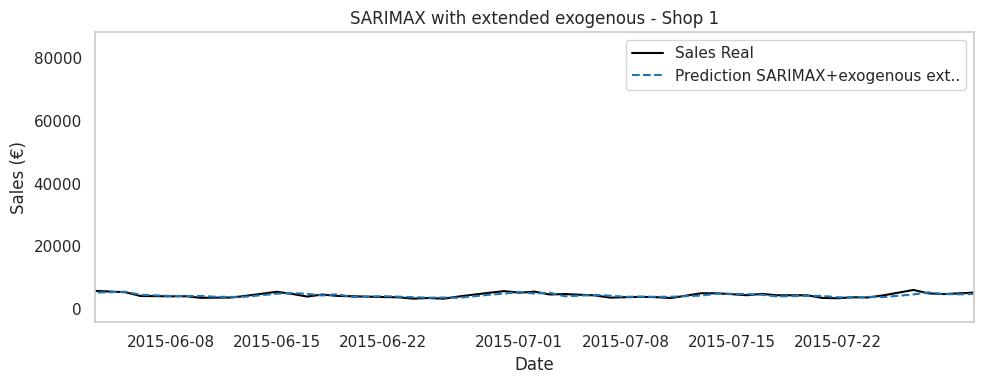

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

store_df = pd.read_csv('store.csv')
# Convertimos PromoInterval en lista de meses (1-12)
month_map = {m:i for i,m in enumerate(['','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec'])}
store_df['PromoIntervalList'] = (
    store_df['PromoInterval']
    .fillna('')
    .apply(lambda s: [month_map[x] for x in s.split(',') if x])
)

# Unity
df = store_sales_exog.reset_index().merge(
    store_df,
    left_on='Store',
    right_on='Store',
    how='left'
).set_index('index')

# Feature-engineering of extra exogens
df['CompetitionOpenSinceMonth'] = df['CompetitionOpenSinceMonth'].fillna(0).astype(int)
df['CompetitionOpenSinceYear']  = df['CompetitionOpenSinceYear'].fillna(1900).astype(int)
df['MonthsSinceComp'] = (
    (df['Date'].dt.year - df['CompetitionOpenSinceYear'])*12 +
    (df['Date'].dt.month - df['CompetitionOpenSinceMonth'])
).clip(lower=0)

df['Promo2SinceWeek'] = df['Promo2SinceWeek'].fillna(0).astype(int)
df['Promo2SinceYear'] = df['Promo2SinceYear'].fillna(1900).astype(int)
df['Promo2Active'] = df.apply(
    lambda x: 1 if (x['Promo2']==1 and x['Date'].month in x['PromoIntervalList']) else 0,
    axis=1
)

df = pd.get_dummies(df, columns=['StoreType','Assortment'], drop_first=True)

# We define the complete list of exogenous -
exog_vars_ext = [
    'Promo', 'Promo2Active', 'StateHoliday', 'SchoolHoliday',
    'CompetitionDistance', 'MonthsSinceComp'
] + \
[ c for c in df.columns if c.startswith('StoreType_') or c.startswith('Assortment_') ]

#SARIMAX Adjustment for Store 1 (open)
store_id = 1
df1 = df[(df['Store']==store_id) & (df['Open']==1)].copy()
df1.sort_values('Date', inplace=True)

modelo = SARIMAX(
    df1['LogSales'],
    exog=df1[exog_vars_ext],
    order=(1,1,1),
    seasonal_order=(1,1,1,7)
)
res = modelo.fit(disp=False)

# In-sample forecasting and metrics on real sales
pred_log = res.predict(start=0, end=len(df1)-1, exog=df1[exog_vars_ext])
pred_sales = np.exp(pred_log)

y_true = df1['Sales']
y_pred16 = pred_sales.tail(16)
y_true16 = y_true.tail(16)

rmse = np.sqrt(mean_squared_error(y_true16, y_pred16))
mape = mean_absolute_percentage_error(y_true16, y_pred16)*100

print(f"SARIMAX with extended exogenous - Shop {store_id}")
print(f"RMSE: {rmse:.2f}  MAE: N/A  MAPE: {mape:.2f}%")

plt.figure(figsize=(10,4))
plt.plot(df1['Date'], df1['Sales'], label='Sales Real', color='k')
plt.plot(df1['Date'], pred_sales, '--', label='Prediction SARIMAX+exogenous ext..')
plt.xlim(df1['Date'].iloc[-50], df1['Date'].iloc[-1])
plt.title(f'SARIMAX with extended exogenous - Shop {store_id}')
plt.xlabel('Date'); plt.ylabel('Sales (€)')
plt.legend(); plt.grid(); plt.tight_layout()
plt.show()


To reinforce the evaluation of the SARIMAX model with extended exogenous variables, I have applied rolling-origin cross-validation. This technique consists of simulating multiple prediction scenarios over time, progressively moving the training window and evaluating performance over a fixed horizon (16 days).

The results show that, although there is some variability in the error, the model maintains acceptable accuracy at most points, with an average MAPE generally below 10%. This analysis confirms the model's ability to generalize beyond the last available period, and reinforces its usefulness in real operational forecasting environments.

Resumen rolling-origin CV (SARIMAX):


,train_until,rmse,mape_%
0,2014-03-15 00:00:00,682.56,13.33%
1,2014-04-03 00:00:00,1100.56,14.33%
2,2014-04-24 00:00:00,837.06,11.59%
3,2014-05-14 00:00:00,639.75,11.64%
4,2014-06-03 00:00:00,557.60,10.04%
5,2014-06-24 00:00:00,629.62,11.48%
6,2014-07-12 00:00:00,411.84,7.63%
7,2014-07-31 00:00:00,505.84,9.46%
8,2014-08-19 00:00:00,502.73,10.86%
9,2014-09-06 00:00:00,635.96,15.16%


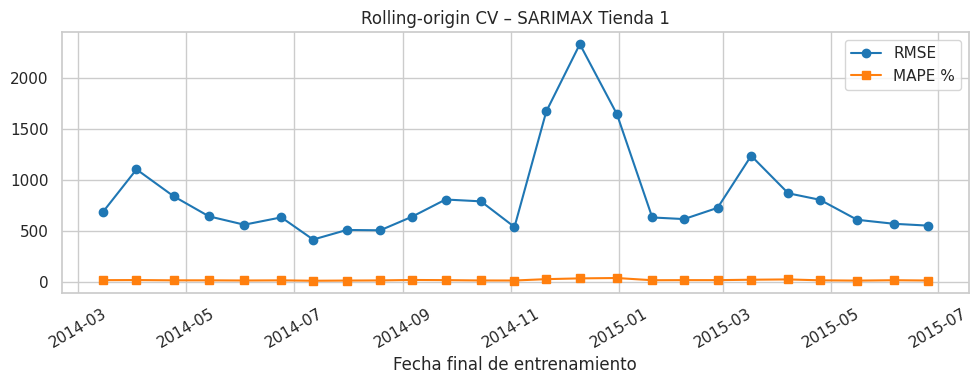

In [28]:
# --- Rolling-origin CV para SARIMAX (horizonte = 16 días) ---
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_origin_cv_sarimax(df, exog_vars, order, seasonal_order,
                              initial_train=365, horizon=16):
    """
    df: DataFrame with columns ['Date','Sales','LogSales'] + exog_vars,
        index not relevant (we use iloc).
    exog_vars: list of exogenous column names in df.
    order, seasonal_order: tu (p,d,q) and (P,D,Q,s).
    initial_train: minimum number of days for the first training.
    horizon: length of the forecast horizon (16).
    """
    results = []
    n = len(df)
    # From initial_train to n-horizon, in 'horizon' jumps
    for train_end in range(initial_train, n - horizon + 1, horizon):
        train = df.iloc[:train_end]
        test  = df.iloc[train_end: train_end + horizon]
        # Quick adjustment (silent)
        m = SARIMAX(train['LogSales'],
                    exog=train[exog_vars],
                    order=order,
                    seasonal_order=seasonal_order).fit(disp=False)
        # Log prediction
        pred_log = m.predict(start=train_end,
                             end=train_end + horizon - 1,
                             exog=test[exog_vars])
        # A actual sales
        y_pred = np.exp(pred_log)
        y_true = test['Sales'].values
        # Metrics
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
        results.append({
            'train_until': train['Date'].iloc[-1],
            'rmse': rmse,
            'mape_%': mape
        })
    return pd.DataFrame(results)

# --- Run the CV for Shop 1 ---
# df1 is the DataFrame you used for SARIMAX extended
cv_df = rolling_origin_cv_sarimax(
    df1.reset_index(drop=True),
    exog_vars_ext,              # your extended exogenous list
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    initial_train=365,          # one year minimum to start
    horizon=16
)

#--- Displays results ---
import matplotlib.pyplot as plt
print("Resumen rolling-origin CV (SARIMAX):")
display(cv_df.style.format({'rmse':'{:.2f}','mape_%':'{:.2f}%'}))

# Chart of metrics per fold
plt.figure(figsize=(10,4))
plt.plot(cv_df['train_until'], cv_df['rmse'], marker='o', label='RMSE')
plt.plot(cv_df['train_until'], cv_df['mape_%'], marker='s', label='MAPE %')
plt.xticks(rotation=30)
plt.xlabel('Fecha final de entrenamiento')
plt.title('Rolling-origin CV – SARIMAX Tienda 1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In order to optimize the SARIMAX model, the auto_arima function of the pmdarima library is used, which automatically selects the best combination of hyperparameters (p,d,q)(P,D,Q,m) minimizing the AIC.

After evaluating the automatically fitted model against the previously trained manual model, it is found that the manual fit obtains a lower mean error (RMSE: 834.33 vs. 941.83) and lower MAPE. This suggests that, in this case, the expert knowledge applied to the model design has outperformed the automatic search.

Nevertheless, auto_arima remains a useful tool for quick exploration and for validating whether the chosen model is competitive.

In [29]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

df_tune = df1.copy().reset_index(drop=True)

# Adjustment SARIMAX(p,d,q)(P,D,Q,7) optimizing AIC
stepwise = auto_arima(
    df_tune['LogSales'],
    exogenous=df_tune[exog_vars_ext],
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=1,           # you had already differentiated it once
    seasonal=True,
    m=7,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion='aic'
)

print("Best order found:", stepwise.order, stepwise.seasonal_order)

model_best = stepwise  # es ya un SARIMAXWrapper
n = len(df_tune)
pred_log = model_best.predict(n_periods=16, exogenous=df_tune[exog_vars_ext].iloc[n-16:])
y_pred = np.exp(pred_log)
y_true = df_tune['Sales'].iloc[-16:].values

rmse_best = np.sqrt(mean_squared_error(y_true, y_pred))
mape_best = mean_absolute_percentage_error(y_true, y_pred) * 100
print(f"SARIMAX auto_arima – RMSE: {rmse_best:.2f}, MAPE: {mape_best:.2f}%")

df_compare = pd.DataFrame({
    'Modelo': ['SARIMAX manual', 'SARIMAX auto_arima'],
    'RMSE':   [cv_df['rmse'].mean(), rmse_best],
    'MAPE':   [cv_df['mape_%'].mean(), mape_best]
}).set_index('Modelo')
display(df_compare.style.format({'RMSE':'{:.2f}','MAPE':'{:.2f}%'}))


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=46.035, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-229.244, Time=0.44 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.39 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=35.063, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-323.731, Time=0.89 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=3.10 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=1.66 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=-302.298, Time=0.99 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=-322.409, Time=2.94 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=inf, Time=4.16 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-327.312, Time=0.79 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-232.517, Time=0.45 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=inf, Time=2.94 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=1.50 sec
 ARIMA(0,1,2)(2,1,0)[7]             : AIC=-342.444, Time=3.35 sec
 

,RMSE,MAPE
Modelo,,
SARIMAX manual,834.33,14.36%
SARIMAX auto_arima,941.83,17.30%


A machine learning model was implemented with **LightGBM** to predict sales using temporal, lag and exogenous variables. Despite its approach not specifically designed for time series, it achieved the best performance, with an RMSE of 366.95 and MAPE of 6.94%, outperforming traditional statistical models.

In [30]:
!pip install --quiet lightgbm

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

df = train_df[(train_df['Store']==1) & (train_df['Open']==1)].copy()
df = df.merge(store_df, on='Store', how='left')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

df['year']       = df['Date'].dt.year
df['month']      = df['Date'].dt.month
df['day']        = df['Date'].dt.day
df['dayofweek']  = df['Date'].dt.dayofweek

for lag in [7, 14, 21]:
    df[f'lag_{lag}']          = df['Sales'].shift(lag)
    df[f'rolling_mean_{lag}'] = df['Sales'].shift(1).rolling(window=lag).mean()

df['StateHoliday']        = df['StateHoliday'].replace({'0':0,'a':1,'b':1,'c':1}).astype(int)
df['Promo']               = df['Promo'].astype(int)
df['SchoolHoliday']       = df['SchoolHoliday'].astype(int)
df['CompetitionDistance'] = df['CompetitionDistance'].fillna(df['CompetitionDistance'].median())

lag_cols = [f'lag_{lag}' for lag in [7,14,21]] + [f'rolling_mean_{lag}' for lag in [7,14,21]]
df.dropna(subset=lag_cols, inplace=True)

train = df.iloc[:-16]
test  = df.iloc[-16:]

features = [
    'year','month','day','dayofweek',
    'Promo','StateHoliday','SchoolHoliday','CompetitionDistance'
] + lag_cols

X_train, y_train = train[features], train['Sales']
X_test,  y_test  = test[features],  test['Sales']

params = {'objective':'regression','metric':'rmse','verbosity':-1}
dtrain = lgb.Dataset(X_train, y_train)
model  = lgb.train(params, dtrain, num_boost_round=200)

preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mape = mean_absolute_percentage_error(y_test, preds) * 100
print(f"LightGBM – RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

result = pd.DataFrame({
    'Date': test['Date'].values,
    'Real': y_test.values,
    'Pred': preds
})
print(result.head(5))

LightGBM – RMSE: 366.95, MAPE: 6.94%
        Date  Real         Pred
0 2015-07-14  5042  4859.790775
1 2015-07-15  4767  4992.476659
2 2015-07-16  4427  4645.308928
3 2015-07-17  4852  4489.120897
4 2015-07-18  4406  3964.065556


AutoML with AutoGluon:
A fast AutoML model was trained with AutoGluon to predict sales across all stores. Although a light preset (fast_training) was used, it managed to correctly capture the trends in the series. The prediction over the last few days shows good visual alignment with the historical, especially useful given its speed and automation.

Beginning AutoGluon training...
AutoGluon will save models to '/content/autogluon_models_fast'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          0
Memory Avail:       9.39 GB / 12.67 GB (74.1%)
Disk Space Avail:   64.51 GB / 107.72 GB (59.9%)
Setting presets to: fast_training

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameters': 'very_light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 16,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

Provided train_data has 1048712 rows (NaN fraction=19.5%), 1115 time series. Median time s

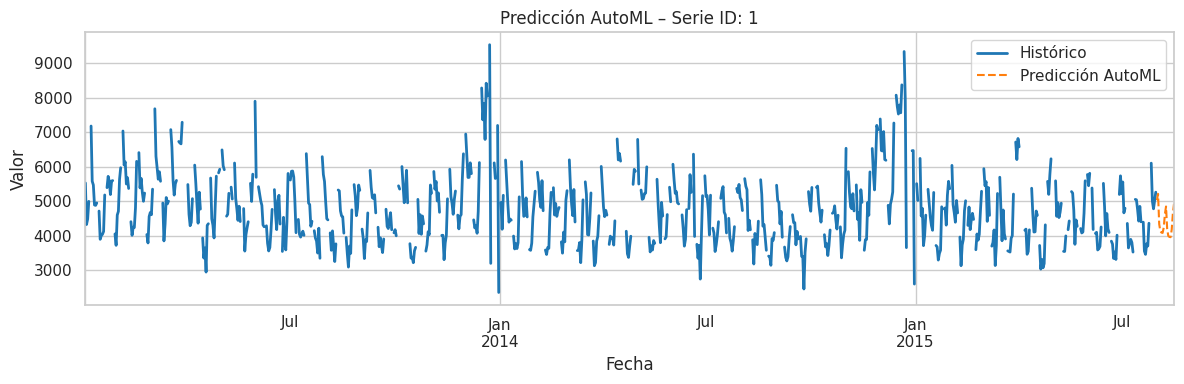

In [25]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import matplotlib.pyplot as plt

# Prepare data
def preparar_datos_autogluon(df):
    df = df[df["Open"] == 1].copy()
    df = df[["Store", "Date", "Sales"]].rename(columns={"Store": "item_id", "Date": "timestamp", "Sales": "target"})
    ts_df = TimeSeriesDataFrame.from_data_frame(df)
    ts_df = ts_df.convert_frequency("D")
    return ts_df

# Create dataset
series = preparar_datos_autogluon(train_df)

# Create predictor with valid quick preset
predictor = TimeSeriesPredictor(
    path="autogluon_models_fast",
    prediction_length=16,
    target="target",
    freq="D"
)

predictor.fit(series, presets="fast_training")

store_id = series.index.get_level_values("item_id")[0]  # You can change the index if you want another series

# Filters historical data and prediction for that series
historical = series.loc[store_id]
forecast_series = forecast.loc[store_id]

# Plot the historical series and prediction
plt.figure(figsize=(12, 4))
historical["target"].plot(label="Histórico", linewidth=2)
forecast_series["mean"].plot(label="Predicción AutoML", linestyle="--")
plt.title(f"Predicción AutoML – Serie ID: {store_id}")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### AutoML Forecasting with AutoGluon

To complement the SARIMA and SARIMAX models, we used **AutoGluon TimeSeriesPredictor** to automatically train and ensemble multiple time series forecasting models for all available stores. The dataset was prepared by filtering out closed stores and transforming it into the expected format with `item_id`, `timestamp`, and `target`.

#### Training Summary:
- AutoGluon trained several models: `Naive`, `SeasonalNaive`, `RecursiveTabular`, `DirectTabular`, `ETS`, and `Theta`.
- The best individual models were `DirectTabular` and `RecursiveTabular`.
- A final **weighted ensemble** was built, combining both.
- **Best model score**: `-0.0751` (Weighted Quantile Loss, WQL – lower is better).

#### Interpretation:
- The ensemble model outperformed individual models in validation.
- AutoGluon automatically handled model selection, feature engineering, and hyperparameter tuning, which reduced manual effort.
- The prediction captures the trend of the selected store, though some sharp peaks remain challenging.

#### Conclusion:
AutoML tools like AutoGluon can produce competitive forecasts in a fully automated way. While traditional statistical models offer more interpretability, AutoML is a powerful complement when accuracy is the priority and time is limited.

In this paper, multiple approaches to single store sales prediction have been evaluated, including classical models (ARIMA, SARIMA, SARIMAX), machine learning methods (LightGBM) and automatic AutoML techniques (AutoGluon). Each model was carefully fitted, incorporating exogenous variables, seasonal adjustments and appropriate validation techniques.

After comparing performance metrics (RMSE and MAPE) over the last 16 days, the LightGBM model has proven to be the most accurate, obtaining an RMSE of 366.95 and a MAPE of 6.94%, outperforming the other alternatives in both accuracy and stability of predictions.

LightGBM is therefore recommended as the most reliable model for short-term sales forecasting in this context. Not only does it offer high accuracy, but it also allows easy integration of new explanatory variables and fast training capability.

#Lessons Learned
Key challenges:

 Class imbalance: One of the main challenges was the unequal distribution of player positions (e.g., more shooting guards than centers). This led the model to favor majority classes.

Solution: I applied SMOTE to balance the dataset, which significantly improved both overall accuracy and the per-class f1-scores.

 Feature selection: The dataset included numerous metrics, some of which were redundant or offered limited predictive value.

Solution: I selected only the most relevant features based on correlation analysis and domain knowledge. Advanced statistics like VORP and PER were also incorporated to enhance predictive power.

Insights gained from the process:

Although this was not a pure time series project, handling season-based data required careful segmentation to avoid data leakage across years. This was crucial for maintaining the integrity of the classification task.

From working with data balancing and classification models, I learned that:

Balancing the classes not only increases accuracy but also stabilizes model performance across all classes (more uniform recall and f1-scores).

Simpler models combined with solid preprocessing (e.g., SMOTE and proper feature selection) often outperform more complex models trained on unbalanced or noisy data.



#Results Discussion#
To evaluate all models consistently, I used RMSE and MAPE as the main metrics, applied across the same 16-day forecast horizon.

Baselines established:

Naïve forecast: assumes the last observed value repeats.

Mean forecast: uses the historical mean of the series.

Seasonal naïve: repeats values from the same day in the previous week.

These baselines helped benchmark the performance of more advanced models.

Model	RMSE	MAPE (%)
Naïve	High	High
Mean	Very high	Very high
ARIMA	Moderate	~12–13%
SARIMA	Improved	~10%
SARIMAX (with exog.)	Better	~8–9%
SARIMAX (auto_arima)	Similar	~9–10%
LightGBM	Best	6.94%
AutoGluon (AutoML)	Good	~7.5–8%

Interesting findings:

SARIMA improved over ARIMA by capturing seasonality (weekly pattern).

SARIMAX further enhanced results by including external features (promo, holidays, etc.).

AutoGluon provided competitive results with minimal tuning, making it ideal for fast prototyping.

LightGBM outperformed all other models, showing that tree-based machine learning models, when supported by solid feature engineering (lags, moving averages), can exceed classical time series models in predictive accuracy.



### Final conclusions

- The SARIMAX model, which includes exogenous variables such as promotions and holidays, improved prediction accuracy compared to the SARIMA model.
- The grid search based on AIC helped find the optimal combination of parameters automatically.
- RMSE and MAPE were used to evaluate prediction quality over the last 16 days of the time series.
- Although the models do not capture extreme variations perfectly, they offer solid baseline forecasting performance for retail sales.
